In [15]:

import re
import torch
from pathlib import Path
from tqdm import tqdm
from transformers import LlamaForCausalLM, LlamaTokenizer, AutoTokenizer
import argparse
import os
from typing import List, Optional, Dict, Iterable, List, Tuple
import numpy as np

from captum.attr import (
    FeatureAblation, 
    GradientShap,
    DeepLiftShap,
    IntegratedGradients,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ShapleyValueSampling,
    KernelShap,
    Lime,
    LLMAttributionResult,
)

import ast
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def load_mappings(txt_path):
    """
    Carga un archivo .txt donde cada línea contiene un diccionario en formato str(dict).
    Devuelve una lista de diccionarios.
    """
    mappings = []
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:  # evitar líneas vacías
                try:
                    d = ast.literal_eval(line)  # convierte str -> dict
                    mappings.append(d)
                except Exception as e:
                    print(f"Error parseando la línea: {line}\n{e}")
    return mappings

def load_prompts(entire_seq_file, aligned_huberts_file, splitter, chunk_size, input_transl=True):
    with open(entire_seq_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
    chunks = [''.join(lines[i:i+chunk_size]) for i in range(0, len(lines), chunk_size)]

    aligned_huberts = load_mappings(aligned_huberts_file)
    
    # ! ESTO MIRAR DE CAMBIAR
    deduplicate = True
    if deduplicate:
        print("Deduplicating hubert tokens...")
        deduplicated_huberts = []
        for d in aligned_huberts:
            new_d = {}
            prev_last = None  # último token de la palabra anterior

            for key, values in d.items():
                if not values:  # lista vacía
                    new_d[key] = values
                    continue

                # empezar collapsed con el primer token
                collapsed = [values[0]]

                # deduplicar consecutivos/prefijos dentro de la lista
                for v in values[1:]:
                    last = collapsed[-1]
                    if repr(v) != repr(last):
                        collapsed.append(v)

                # eliminar al inicio lo que coincida/empiece con la última palabra anterior
                if prev_last is not None and collapsed:
                    while collapsed and (repr(collapsed[0]) == repr(prev_last)):
                        collapsed.pop(0)

                new_d[key] = collapsed
                prev_last = collapsed[-1] if collapsed else prev_last

            deduplicated_huberts.append(new_d)
            aligned_huberts = deduplicated_huberts

    original_prompts, generated_texts = [], []
    for i,chunk in enumerate(chunks):
        parts = re.split(splitter, chunk)
        if len(parts) < 3:
            print(repr(f"Sample number {i} not segmented correctly\nSample: {''.join(parts)}"))
            continue
        original_prompt = parts[0] + parts[1]
        generated_text = ''.join(parts[2:])
        
        if input_transl: original_prompts.append(chunk) 
        else: original_prompts.append(original_prompt)
        generated_texts.append(generated_text)

    return original_prompts, generated_texts, aligned_huberts

def load_attr_method(method: str, model, tokenizer):
    print(f"Attributing with {method}")
    if method == "layer-integrated-gradients":
        attr_method = LayerIntegratedGradients(model, model.model.embed_tokens)
        return LLMGradientAttribution(attr_method, tokenizer)
    elif method == "deeplift-shap":
        attr_method = DeepLiftShap(model, model.model.embed_tokens)
        return LLMAttribution(attr_method, tokenizer)
    elif method == "gradient-shap":
        attr_method = GradientShap(model, model.model.embed_tokens)
        return LLMGradientAttribution(attr_method, tokenizer)
    elif method == "feature-ablation":
        attr_method = FeatureAblation(model)
        return LLMAttribution(attr_method, tokenizer)
    elif method == "kernel-shap":
        attr_method = KernelShap(model)
        return LLMAttribution(attr_method, tokenizer)
    elif method == "lime":
        attr_method = Lime(model)
        return LLMAttribution(attr_method, tokenizer)
    elif method == "shapley-values":
        attr_method = ShapleyValueSampling(model) 
        return LLMAttribution(attr_method, tokenizer)        
    else:
        raise ValueError("Not implemented")
    
def extract_template(input_text, tokenizer, aligned_hubert_words, input_transl=False):
    # --- USER BLOQUE (audio + idioma1) ---
    audio_regex = re.search(
        r"<\|im_start\|>user\s*(.*?)\s*Transcribe in ([\w\s]+)<\|im_end\|>",
        input_text, re.DOTALL
    )
    audio_segment = audio_regex.group(1).strip() if audio_regex else ""
    lang1 = audio_regex.group(2).strip() if audio_regex else ""

    # --- USER BLOQUE (idioma2 para translate) ---
    lang2_match = re.search(r"Translate to ([\w\s]+)", input_text)
    lang2 = lang2_match.group(1).strip() if lang2_match else ""

    # --- ASSISTANT BLOQUES (transcripción y opcionalmente traducción) ---
    assistant_blocks = re.findall(
        r"<\|im_start\|>assistant\s*(.*?)\s*(?=(<\|im_end\|>|$))",
        input_text, re.DOTALL
    )
    transc_segment = assistant_blocks[0][0].strip() if assistant_blocks else ""
    transl_segment = (
        assistant_blocks[-1][0].strip()
        if (assistant_blocks and input_transl and len(assistant_blocks) > 1)
        else ""
    )

    # --- normalización segura (convierte None -> "", quita saltos) ---
    def norm(s: Optional[str]) -> str:
        s = s or ""
        return re.sub(r'(?:\r\n|\r|\n|\\n)+', ' ', s).strip()

    audio_segment = norm(audio_segment)
    transc_segment = norm(transc_segment)
    transl_segment = norm(transl_segment)

    # --- tokenización ---
    texts_to_tokenize = [audio_segment, transc_segment]
    if input_transl:
        texts_to_tokenize.append(transl_segment)

    token_lists = [
        tokenizer.convert_ids_to_tokens(tokenizer(p, add_special_tokens=False)["input_ids"])
        for p in texts_to_tokenize
    ]

    # --- comprobación de alineación con HuBERT ---
    total_audio_toks = sum(len(v) for v in aligned_hubert_words.values())
    assert len(token_lists[0]) == total_audio_toks, (
        f"Desajuste audio: {len(token_lists[0])} vs {total_audio_toks}"
    )

    # --- plantillas ---
    audiotok_str = ''.join([f"{{audiotok_{i}}}" for i in range(len(token_lists[0]))])
    transctok_str = ''.join([f"{{transctok_{i}}}" for i in range(len(token_lists[1]))])

    audio_template = "<|im_start|>user\n" + audiotok_str + "\n"
    transc_template = "Transcribe in {language1}<|im_end|>\n<|im_start|>assistant\n" + transctok_str + "\n"
    transl_template = "<|im_end|><|im_start|>user\nTranslate to {language2}<|im_end|>\n<|im_start|>assistant\n"

    if input_transl:
        transltok_str = ''.join([f"{{transltok_{i}}}" for i in range(len(token_lists[2]))])
        transl_template += transltok_str

    template = audio_template + transc_template + transl_template

    # --- values ---
    values = {}
    values.update({f"audiotok_{i}": tok for i, tok in enumerate(token_lists[0])})
    values["language1"] = lang1
    values.update({f"transctok_{i}": tok for i, tok in enumerate(token_lists[1])})
    values["language2"] = lang2
    if input_transl:
        values.update({f"transltok_{i}": tok for i, tok in enumerate(token_lists[2])})

    # --- mask ---
    mask = {}
    counter = 0
    for word_idx, (_, tokens) in enumerate(aligned_hubert_words.items()):
        for _ in tokens:
            mask[f"audiotok_{counter}"] = word_idx
            counter += 1

    mask["language1"] = max(mask.values()) + 1
    start_transc = max(mask.values()) + 1
    for i in range(len(token_lists[1])):
        mask[f"transctok_{i}"] = start_transc + i

    mask["language2"] = max(mask.values()) + 1
    if input_transl:
        start_transl = max(mask.values()) + 1
        for i in range(len(token_lists[2])):
            mask[f"transltok_{i}"] = start_transl + i

    return template, values, mask

def load_model(CKPT):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = LlamaForCausalLM.from_pretrained(CKPT,device_map="auto",torch_dtype=torch.float16)
    model.eval() 
    tokenizer = AutoTokenizer.from_pretrained(CKPT)
    
    return model, tokenizer

def gradient_attribution(input_texts, generated_texts, aligned_huberts, tokenizer, llm_attr, skip_tokens, **kwargs):
    skip_tokens = kwargs.get("skip_tokens", [])
    for i, (input_text, generated_text) in tqdm(enumerate(zip(input_texts, generated_texts)), total=len(input_texts)):
        inp = TextTokenInput(
            input_text, 
            tokenizer,
            skip_tokens=skip_tokens,
        )
        
        attr_res = llm_attr.attribute(inp, target=generated_text)
        attr_res.plot_token_attr(show=True)
        
def perturbation_attribution(input_texts, generated_texts, aligned_huberts, tokenizer, llm_attr, skip_tokens, **kwargs):
    attr_method = kwargs.get("attr_method", None)
    attribution_kwargs = kwargs.get("attribution_kwargs", {})
    
    for i, (input_text, generated_text, aligned_hubert_words) in tqdm(enumerate(zip(input_texts, generated_texts, aligned_huberts)), total=len(input_texts)):
        template, values, mask = extract_template(input_text, tokenizer, aligned_hubert_words, input_transl=False) # AQUI MAL!!!!!
        inp = TextTemplateInput(template, 
            values=values, 
            mask=mask,
        )
        
        attr_res = llm_attr.attribute(inp, target=generated_text, skip_tokens=skip_tokens, **attribution_kwargs)
        sft_attr_res = group_scores(attr_res, values)       
        sft_attr_res.plot_token_attr(show=True)
        
        audio_words, audio_start_idx, audio_end_idx = build_audio_spans(aligned_hubert_words)
        format_attr_res = collapse_multiple_input_spans(sft_attr_res, audio_start_idx, audio_end_idx, audio_words, reduce="mean")
        format_attr_res.plot_token_attr(show=True)
        
        
def build_audio_spans(audio_dict: Dict[str, Iterable]) -> Tuple[List[str], List[int], List[int]]:
    """
    Devuelve:
      - audio_words: ['/' + palabra + '/'] en orden de inserción
      - audio_start_idx: inicios acumulados (0-based)
      - audio_end_idx: finales EXCLUSIVOS (uno-pasado-del-último)
    """
    audio_words: List[str] = []
    audio_start_idx: List[int] = []
    audio_end_idx: List[int] = []

    offset = 0
    for key, vals in audio_dict.items():
        n = len(vals)
        audio_words.append(f"/{key}/")
        audio_start_idx.append(offset)
        offset += n-1
        audio_end_idx.append(offset)
        offset += 1

    return audio_words, audio_start_idx, audio_end_idx

         
def group_scores(attr_res, values):
    new_token_attr = []

    for row in attr_res.token_attr:
        # calcular softmax sobre valores únicos
        unique_vals = row.unique()
        softmax_vals = torch.softmax(unique_vals, dim=0)

        # mapear cada valor a su probabilidad
        val_to_prob = {val.item(): prob.item() for val, prob in zip(unique_vals, softmax_vals)}
        mapped_row = torch.tensor([val_to_prob[val.item()] for val in row], dtype=torch.float32)
        new_token_attr.append(mapped_row)

    new_token_attr = torch.stack(new_token_attr)
    num_rows = new_token_attr.size(0)

    audio_count = sum("audiotok" in key for key in values)
    transc_count = sum("transctok" in key for key in values)
    # separar atributos según límites dados
    audio_attr = new_token_attr[2:, :audio_count]
    transc_attr = new_token_attr[2:, audio_count+2:audio_count+2+transc_count] #teniendo en cuenta lo de english 
    transl_attr = new_token_attr[2:, audio_count+3+transc_count:] #teniendo en cuenta lo de english + catalan
    transc_in_attr = new_token_attr[2:, audio_count+1] #english
    transl_to_attr = new_token_attr[2:, audio_count+3+transc_count] #english
    

    # calcular promedios
    audio_sum = audio_attr.unique().sum() / num_rows
    transc_sum = transc_attr.unique().sum() / num_rows
    transl_sum = transl_attr.unique().sum() / num_rows
    transc_in_sum = transc_in_attr.unique().sum() / num_rows
    transl_to_sum = transl_to_attr.unique().sum() / num_rows
    

    #! QUITAR LAS LANGS O PONERLAS
    print(f"AUDIO: {audio_sum:.4f}, TRANSCRIPT: {transc_sum:.4f}, TRANSLATION: {transl_sum:.4f}, Transcribe in _: {transc_in_score:.4f}, Translate to _: {transl_to_score:.4f}")

    new_attr_res = LLMAttributionResult(
        seq_attr=attr_res.seq_attr,
        token_attr=new_token_attr,
        input_tokens=attr_res.input_tokens,
        output_tokens=attr_res.output_tokens
    )
    
    return new_attr_res   

def _collapse_input_span(
    attr_res: LLMAttributionResult,
    start: int,
    end: int,
    new_name: str,
    reduce: str = "mean",   # "sum" o "mean"
) -> LLMAttributionResult:
    if end < start:
        raise ValueError("end debe ser >= start")

    t = attr_res.token_attr  # esperado: (n_output_tokens, n_input_tokens)

    if isinstance(t, torch.Tensor):
        mid = t[:, start:end+1]
        agg = mid.sum(dim=1, keepdim=True) if reduce == "sum" else mid.mean(dim=1, keepdim=True)
        new_t = torch.cat([t[:, :start], agg, t[:, end+1:]], dim=1)

    elif isinstance(t, np.ndarray):
        mid = t[:, start:end+1]
        agg = mid.sum(axis=1, keepdims=True) if reduce == "sum" else mid.mean(axis=1, keepdims=True)
        new_t = np.concatenate([t[:, :start], agg, t[:, end+1:]], axis=1)
    else:
        raise TypeError("token_attr debe ser torch.Tensor o np.ndarray")

    new_input_tokens = (
        attr_res.input_tokens[:start] + [new_name] + attr_res.input_tokens[end+1:]
    )

    if new_t.shape[1] != len(new_input_tokens):
        raise RuntimeError("Desajuste entre columnas de token_attr y input_tokens.")

    return LLMAttributionResult(
        seq_attr=attr_res.seq_attr,
        token_attr=new_t,
        input_tokens=new_input_tokens,
        output_tokens=attr_res.output_tokens
    )

def collapse_multiple_input_spans(
    attr_res: LLMAttributionResult,
    starts: List[int],
    ends: List[int],
    names: Optional[List[str]] = None,
    reduce: str = "mean",
) -> LLMAttributionResult:
    """
    Colapsa varios rangos [start_i, end_i] -> una columna cada uno,
    reemplazando los nombres por names[i]. Equivalente a llamar varias
    veces a collapse_input_span. Se procesan de derecha a izquierda.
    """
    if len(starts) != len(ends):
        raise ValueError("starts y ends deben tener la misma longitud.")

    n = len(starts)
    if names is None:
        names = [f"[SPAN_{i}]" for i in range(n)]
    elif len(names) != n:
        raise ValueError("Si se proporciona, names debe tener la misma longitud que starts/ends.")

    spans = sorted(zip(starts, ends, names), key=lambda x: x[0])  # ascendente
    for i in range(len(spans)):
        s, e, _ = spans[i]
        if e < s:
            raise ValueError(f"Span inválido: ({s}, {e})")
        if i > 0:
            prev_s, prev_e, _ = spans[i-1]
            if s <= prev_e:  # solapan (o contiguos con s == prev_e+1 son válidos si quieres)
                raise ValueError(f"Spans solapados o no ordenados: ({prev_s},{prev_e}) y ({s},{e})")

    for s, e, nm in sorted(spans, key=lambda x: x[0], reverse=True):
        attr_res = _collapse_input_span(attr_res, s, e, nm, reduce=reduce)

    return attr_res


def plot_attr_heatmap(attr_res, cmap="coolwarm", center_at_zero=True, dpi=120):
    # token_attr: [n_output_tokens, n_input_tokens]
    M = attr_res.token_attr
    if hasattr(M, "detach"):
        M = M.detach().cpu().numpy()
    else:
        M = np.asarray(M)

    # centrado en 0 si hay signos opuestos
    if center_at_zero and (M.min() < 0) and (M.max() > 0):
        norm = TwoSlopeNorm(vcenter=0.0, vmin=M.min(), vmax=M.max())
    else:
        norm = None

    fig, ax = plt.subplots(figsize=(max(8, M.shape[1]*0.25), max(5, M.shape[0]*0.35)), dpi=dpi)
    im = ax.imshow(M, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)

    ax.set_xticks(np.arange(M.shape[1]))
    ax.set_xticklabels(attr_res.input_tokens, rotation=90)
    ax.set_yticks(np.arange(M.shape[0]))
    ax.set_yticklabels(attr_res.output_tokens)

    cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    cbar.ax.set_ylabel("attribution", rotation=90, va="center")
    ax.grid(False)
    plt.tight_layout()
    plt.show()

# # Usos:
# plot_attr_heatmap(attr_res, cmap="magma")      # secuencial
# plot_attr_heatmap(attr_res, cmap="coolwarm")   # divergente, 0 en blanco si hay positivos/negativos
              
def main(args):
    CKPT = Path(args.checkpoint_path)
    OUTPUT_DIR = Path(args.output_dir)
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    model, tokenizer = load_model(CKPT)
    
    lang_pairs = ["en_ca", "en_es", "en_pt"]
    for lang_pair in lang_pairs:
        llm_attr = load_attr_method(args.attr_method, model, tokenizer)
        results_file_config = {
            "entire_seq_file": os.path.join(args.results_dir, f"{lang_pair}.entire_sequence.txt"),
            "aligned_huberts_file": f"/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/captum/results/s2tt-cot/fleurs-alignment/{lang_pair}.aligned_huberts.txt", # os.path.join(args.results_dir, f"{lang_pair}.aligned_huberts.txt")
            "splitter": args.splitter,
            "chunk_size": args.chunk_size,
            "input_transl": True,
        }
        
        input_texts, generated_texts, aligned_huberts = load_prompts(**results_file_config)

        if args.no_special_tokens == True:
            skip_tokens = ["<0x0A>", "<|im_end|>", "<|im_start|>", " assistant", "assistant", "assistant\\",
                           "user", "\n", "n", "\\", "<s>", "\\", "\\n"]
        else: skip_tokens = []
        
        attribution_kwargs = getattr(args, "attribution_kwargs", {})
        attr_fn = gradient_attribution if "gradients" in args.attr_method else perturbation_attribution
        attr_fn(input_texts, generated_texts, aligned_huberts, tokenizer, llm_attr, skip_tokens, attr_method=args.attr_method, attribution_kwargs=attribution_kwargs)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Attributing with shapley-values
Deduplicating hubert tokens...


  0%|          | 0/647 [00:00<?, ?it/s]

AUDIO: 0.2988, TRANSCRIPT: 0.5701, TRANSLATION: 0.0000


/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983301 (\N{VS50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983127 (\N{NBH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983295 (\N{VS44}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983366 (\N{VS115}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projec

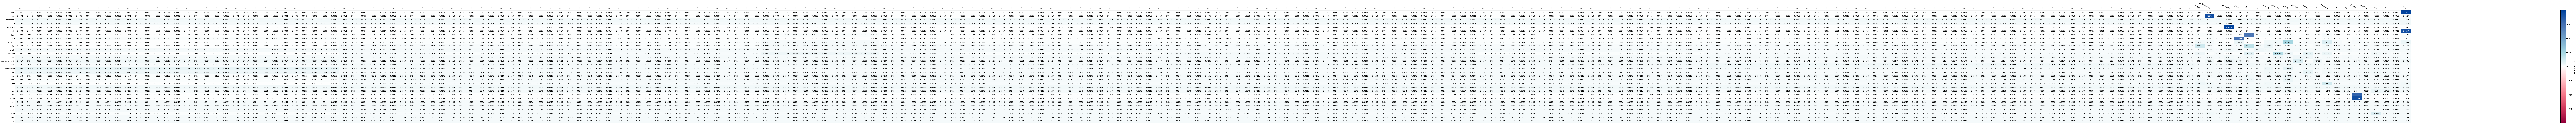

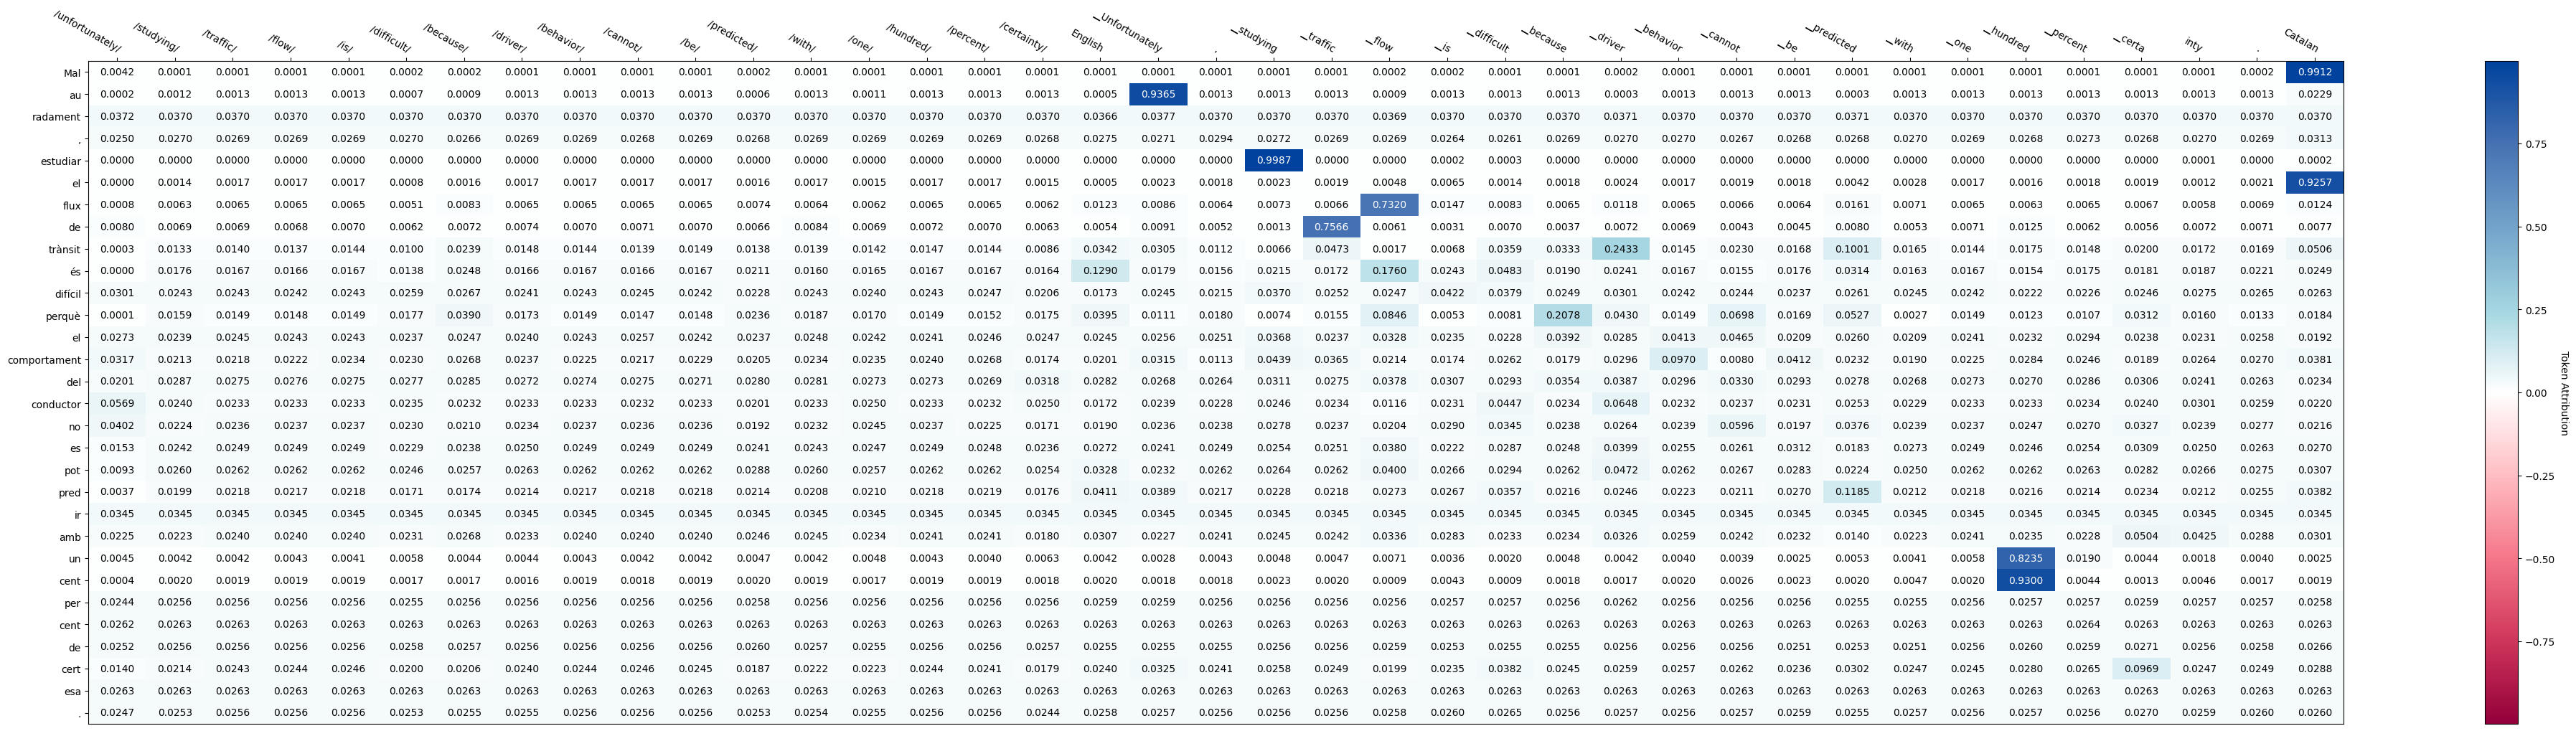

  0%|          | 1/647 [00:40<7:18:39, 40.74s/it]

AUDIO: 0.3117, TRANSCRIPT: 0.5822, TRANSLATION: 0.0000


/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983047 (\N{ETX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983369 (\N{VS118}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983318 (\N{VS67}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983307 (\N{VS56}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projec

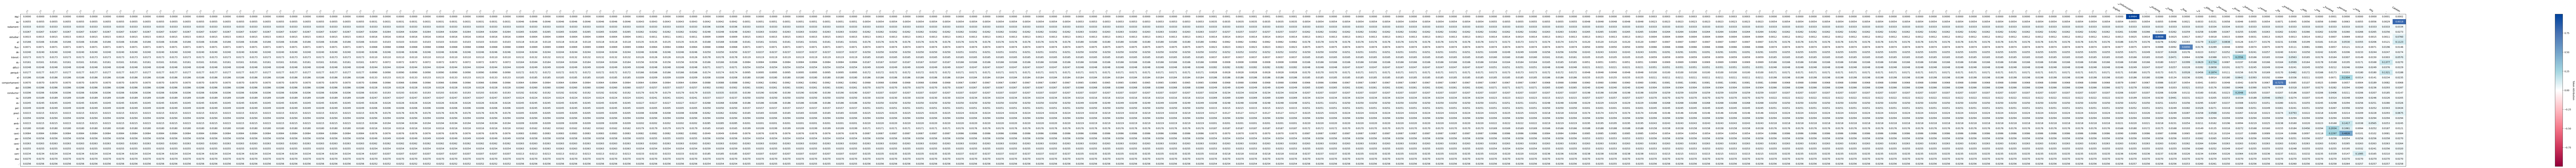

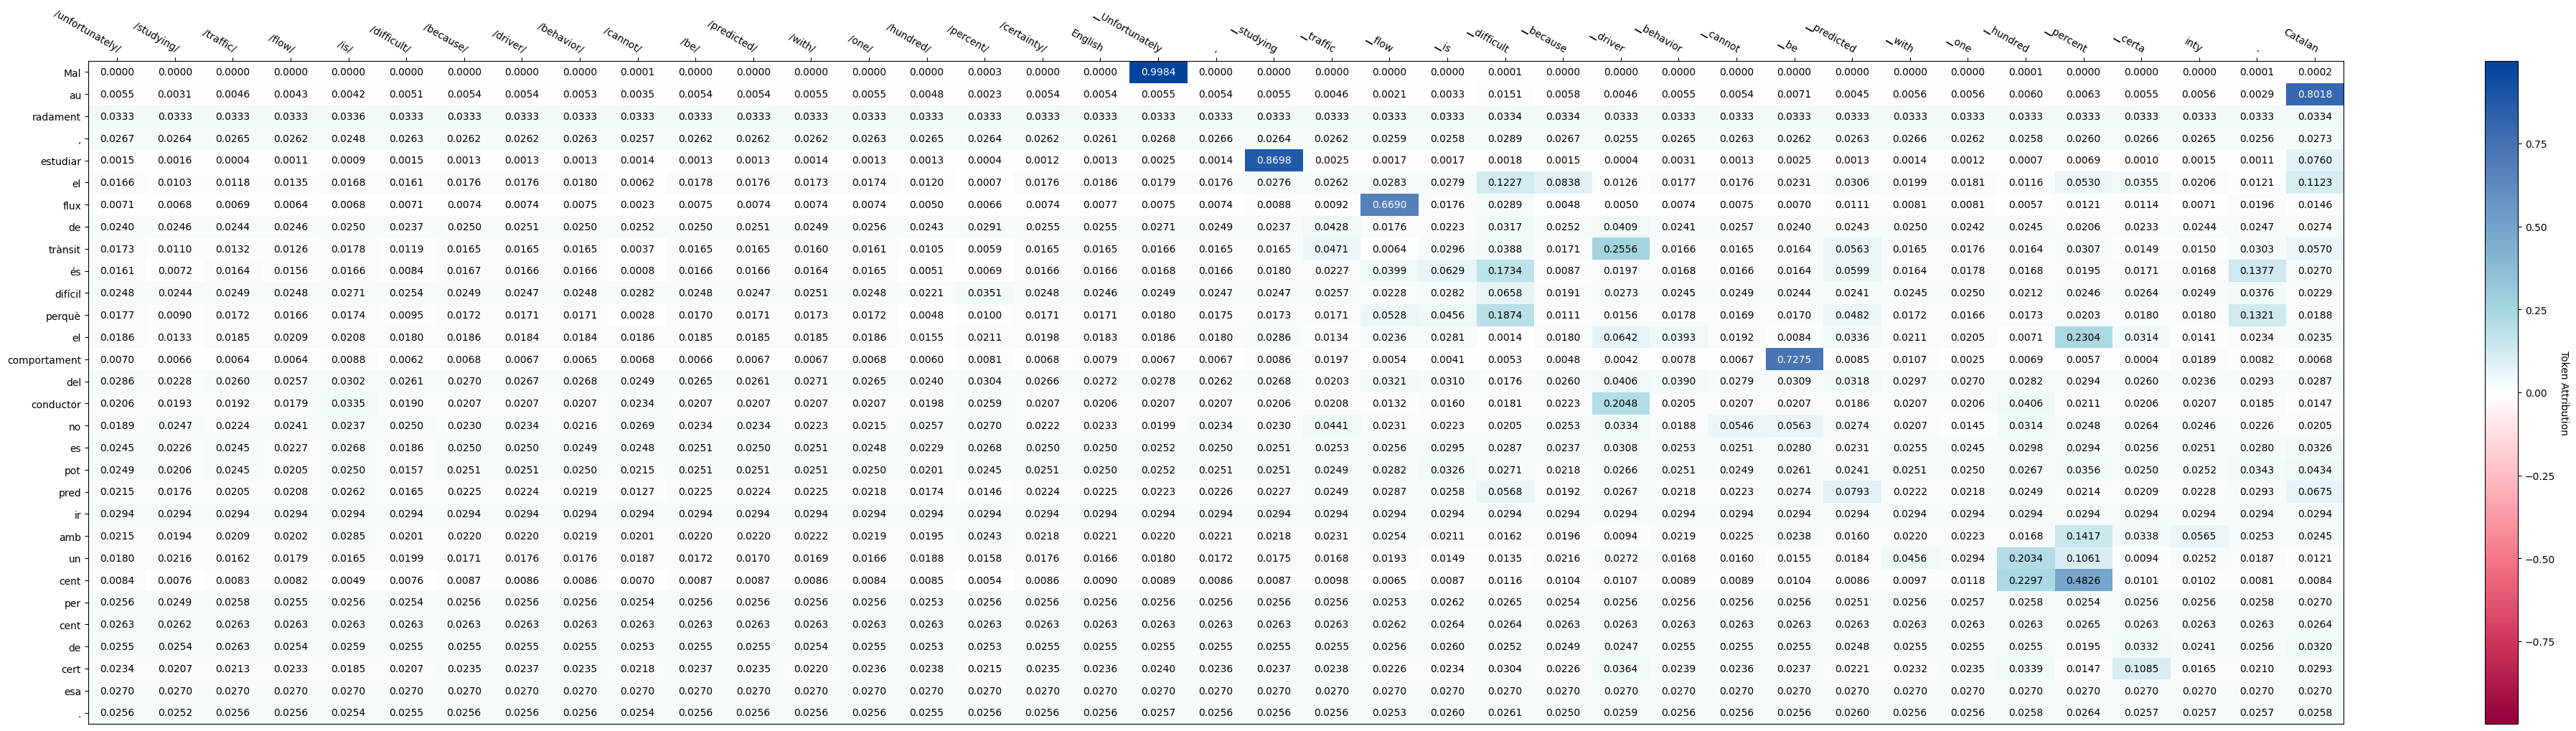

  0%|          | 2/647 [01:16<6:45:01, 37.68s/it]

AUDIO: 0.2534, TRANSCRIPT: 0.6391, TRANSLATION: 0.0000


/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983047 (\N{ETX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983366 (\N{VS115}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983450 (\N{VS199}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 983214 (\N{FVS2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/gpfs/proje

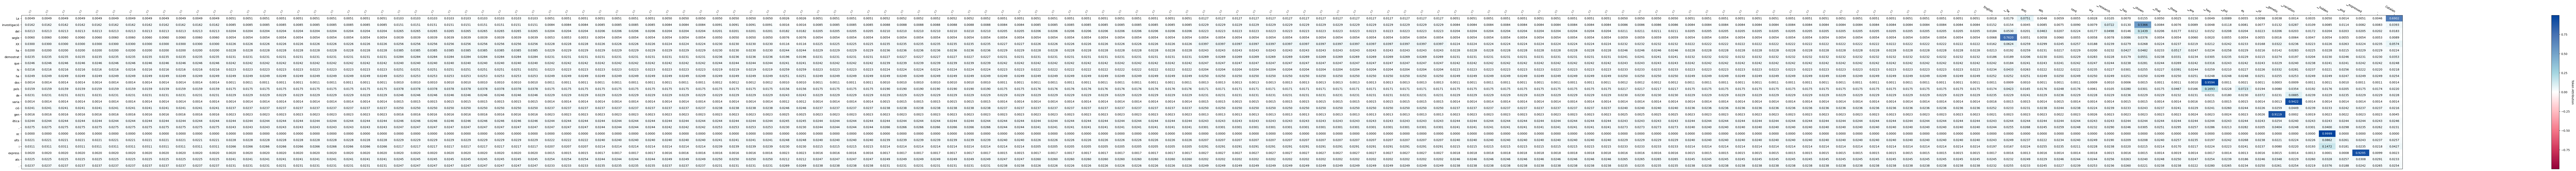

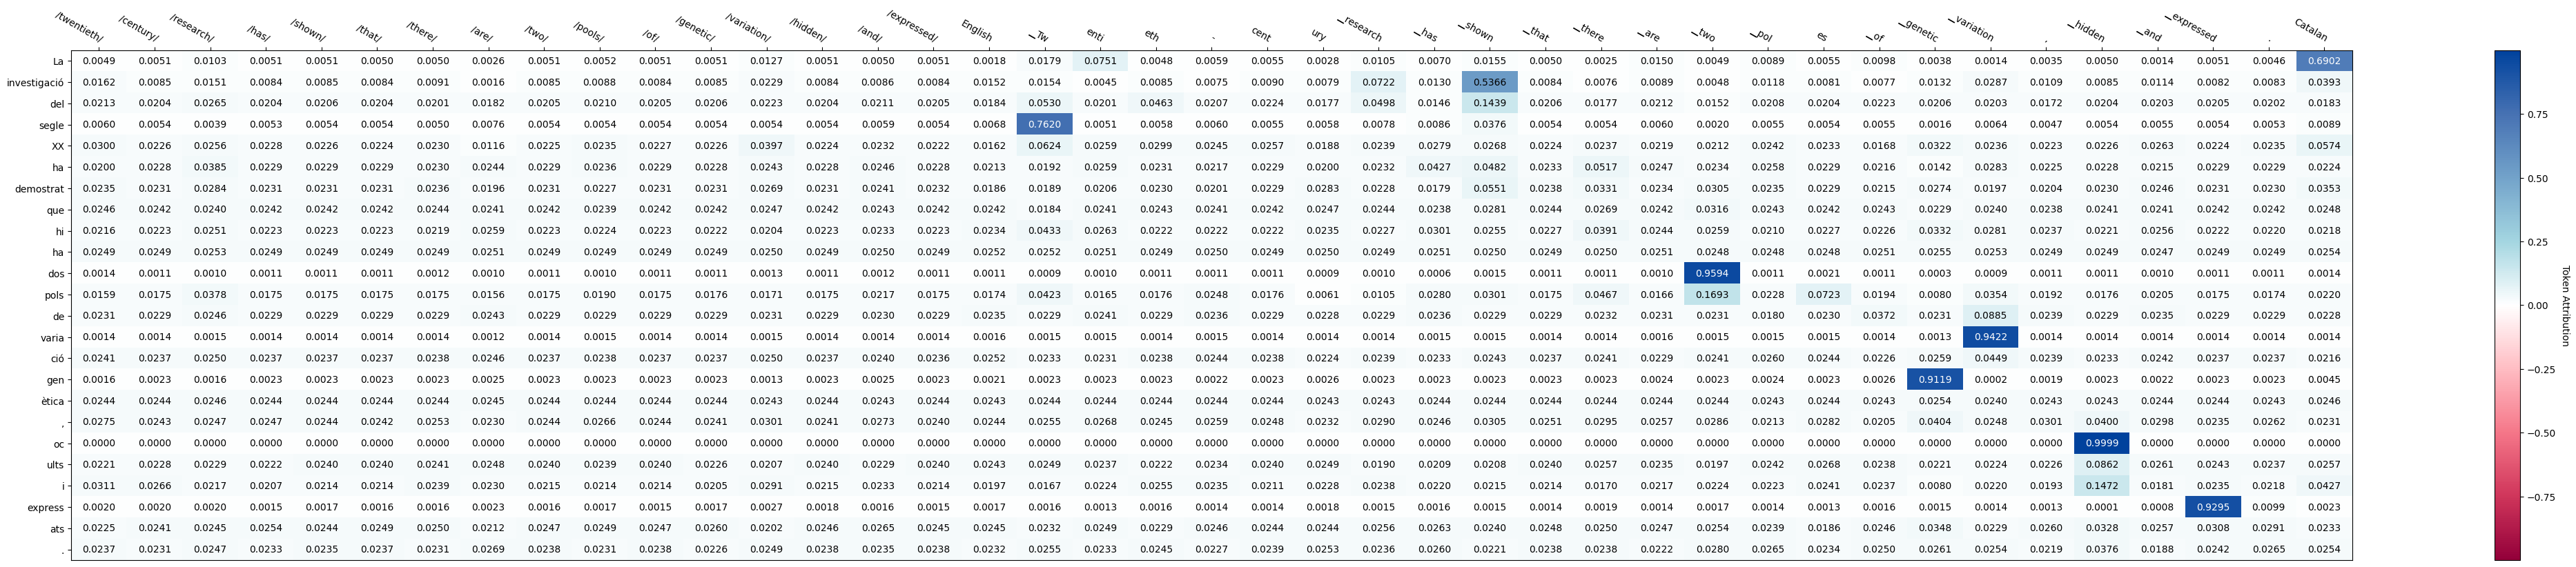

  0%|          | 3/647 [02:05<7:30:04, 41.93s/it]


KeyboardInterrupt: 

In [16]:
from types import SimpleNamespace
from pathlib import Path

# /gpfs/projects/bsc88/speech/mm_s2st/outputs/checkpoints/speech_salamandra/salamandrast-iber/stage2/s2_TA7b-ins-v2_10
# checkpoint_path="/gpfs/projects/bsc88/speech/mm_s2st/repos/speech_salamandra/checkpoints/salamandrast-iber/stage2/s2_TA7b-ins-jacobo",

args = SimpleNamespace(
    checkpoint_path="/gpfs/projects/bsc88/speech/mm_s2st/outputs/checkpoints/speech_salamandra/salamandrast-iber/stage2/s2_TA7b-ins-v2_10",
    results_dir="/gpfs/projects/bsc88/speech/mm_s2st/outputs/results/speech_salamandra/salamandrast-iber/s2_TA7B_ins-v2_10/s2tt-cot/fleurs-test/",
    output_dir="/gpfs/projects/bsc88/speech/research/scripts/Jacobo/s2t/input_att/captum/scores/salamandrast-iber/s2_TA7b-ins-jacobo/en_es",
    attr_method="shapley-values",
    splitter = r'(\\nTranslate to (?:.+?)<\|im_end\|>\\n<\|im_start\|>assistant\\n)',
    chunk_size=1,
    no_special_tokens=True,
    attribution_kwargs={"n_samples": 1}
)

main(args)